In [ ]:
import torch

import .image_encoder.loader as loader
import .image_encoder.utility as utility
import .image_encoder.transformers as transformers

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [29]:
loader_params = {
    "batch_size": 1,
    "pad_images": False,
    "percent_mask": 0.0,
    "shuffle": True
}

dataloader = loader.get_dataloader('dict_traindata.txt', loader_params)
ViT = transformers.VisionTransformer.load_model('image_encoder/trained_models/vit_20241117_sinusoid60k_vF.pth')
ViT = ViT.to(device)

# Visualizing Our Attention

In [50]:
sample_u, sample_attn = None, None
with torch.no_grad():
    ViT.eval()
    for i, (ids, u, u_masks, v, v_masks) in enumerate(dataloader):
        B, H, W = u.shape
        u = u.to(device)

        # Forward pass
        cls_logits, patch_logits, attn = ViT(u, save_attn=True, temperature=1)

        sample_attn = attn[0][0, 1].cpu()
        sample_u = u[0].cpu()
        break

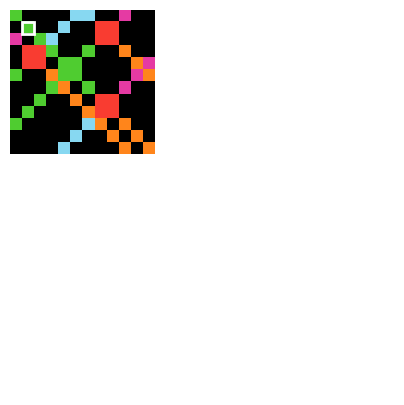

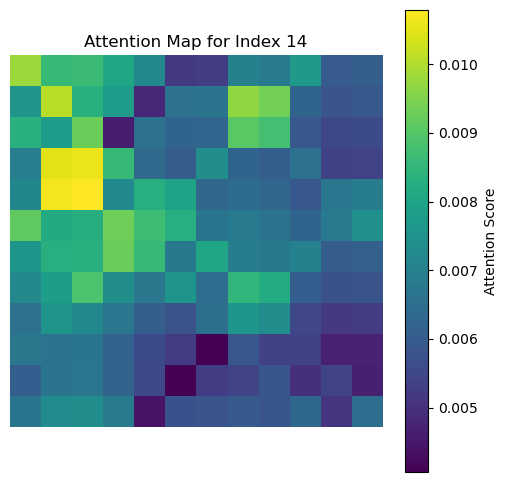

In [53]:
idx = utility.get_idx(x=1, y=1, CLS=False, size=sample_u.shape)
utility.plot_tensor_with_highlight(sample_u, idx)
utility.plot_attention_map(sample_attn, idx, size=sample_u.shape)

# Cosine Sim on CLS Token

In [ ]:
# This will take some time -- it is generating CLS token embeddings for all images in the dataset
ids_list = []
images_tensor = []
cls_tensor = []

with torch.no_grad():
    ViT.eval()
    for i, (ids, u, u_masks, v, v_masks) in enumerate(dataloader):
        B, H, W = u.shape
        u = u.to(device)

        cls_logits, _, _ = ViT(u, save_attn=False, temperature=1)

        ids_list.extend(ids)
        images_tensor.append(u.cpu())
        cls_tensor.append(cls_logits[:, 0].cpu())
        
    images_tensor = torch.cat(images_tensor, dim=0)
    cls_tensor = torch.cat(cls_tensor, dim=0)

In [ ]:
# Compute cosine similarity for given id
# id  = 'd4a91cb9-train-output-1'
# idx = ids_list.index(id)
idx = 30

print(f"ID: {id}")
utility.plot_tensors_with_colors(images_tensor[idx:idx+1], f"ID: {id}")
print(f"{'='*60}\n")

# Compute our closest and furthest embeddings
k = 10
closest_embeddings, closest_sims = utility.top_k_cosine_similarity(cls_tensor, idx, k, largest=True)
furthest_embeddings, furthest_sims = utility.top_k_cosine_similarity(cls_tensor, idx, k, largest=False)


print(f"Closest {k} images:")
for i, closest_idx in enumerate(closest_embeddings):
    closest_id = ids_list[closest_idx]
    utility.plot_tensors_with_colors(images_tensor[closest_idx:closest_idx+1], f"ID: {closest_id}")
    print(f"Similarity = {closest_sims[i]:.3f}\n")

print(f"Furthest {k} images:")
for i, furthest_idx in enumerate(furthest_embeddings):
    furthest_id = ids_list[furthest_idx]
    utility.plot_tensors_with_colors(images_tensor[furthest_idx:furthest_idx+1], f"ID: {furthest_id}")
    print(f"Similarity = {furthest_sims[i]:.3f}\n")